# CLIP Score Evaluation
Compute CLIP alignment scores for images generated by multiple personalization methods using a shared prompt.



In [1]:
# @title  Install dependencies
!pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install -q transformers accelerate evaluate pillow pandas matplotlib tqdm
!git clone https://github.com/huyhuunguyen1705/AI_Avatar_Project.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# @title  Imports & configuration
import glob, os, json, math, tqdm, pandas as pd
from PIL import Image
import torch
from transformers import AutoModel, AutoProcessor
import evaluate
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on", device)


Running on cuda


In [ ]:
# @title  Define prompt and image paths
PROMPT = "(wide shot) of analog style modelshoot style 8k close up linkedin profile picture of a man, professional jack suite, professional headshots, photo-realistic, 4k, high-resolution image, workplace settings, upper body, modern outfit, professional suit, business, blurred background, glass building, office window. crisp details, neutral expression, high-definition"
cl
# Adjust base_dir if different
methods = {
    # ───────── Stable-Diffusion 1.5 ─────────
    'SD15_Dreambooth'       : '/content/AI_Avatar_Project/Generated/SD1.5/Dreambooth/Itay/*.png',
    'SD15_LoRA'             : '/content/AI_Avatar_Project/Generated/SD1.5/LoRA/Itay/*.png',
    'SD15_TextualInversion' : '/content/AI_Avatar_Project/Generated/SD1.5/Textual_Inversion/Itay/*.png',

    # ───────── Stable-Diffusion XL ──────────
    'SDXL_Dreambooth'       : '/content/AI_Avatar_Project/Generated/SDXL/Dreambooth/Itay/*.png',
    'SDXL_LoRA'             : '/content/AI_Avatar_Project/Generated/SDXL/LoRA/Itay/*.png',
    'SDXL_TextualInversion' : '/content/AI_Avatar_Project/Generated/SDXL/Textual_Inversion/Itay/*.png',

    # ───────── Others ────────────
    'InstantID_Hires'       : '/content/AI_Avatar_Project/Generated/InstantID_Hires.fix/*.png',
    'Kohya_LoRA'            : '/content/AI_Avatar_Project/Generated/Kohya_LoRA/Itay/*.png',
}


In [10]:
# @title Build manifest DataFrame
records = []
for method, pattern in methods.items():
    for path in sorted(glob.glob(pattern)):
        records.append({"image_path": path, "prompt": PROMPT, "method": method})
manifest_df = pd.DataFrame(records)
display(manifest_df.head())
print(f"Total images: {len(manifest_df)}")


,image_path,prompt,method
0,/content/AI_Avatar_Project/Generated/SD1.5/Dre...,(wide shot) of analog style modelshoot style 8...,SD15_Dreambooth
1,/content/AI_Avatar_Project/Generated/SD1.5/Dre...,(wide shot) of analog style modelshoot style 8...,SD15_Dreambooth
2,/content/AI_Avatar_Project/Generated/SD1.5/Dre...,(wide shot) of analog style modelshoot style 8...,SD15_Dreambooth
3,/content/AI_Avatar_Project/Generated/SD1.5/Dre...,(wide shot) of analog style modelshoot style 8...,SD15_Dreambooth
4,/content/AI_Avatar_Project/Generated/SD1.5/Dre...,(wide shot) of analog style modelshoot style 8...,SD15_Dreambooth


Total images: 40


In [11]:
# @title Sanity‑check image counts
counts = manifest_df.method.value_counts()
display(counts)
assert all(counts == counts.iloc[0]), "Uneven number of images per method – please fix before continuing!"


,count
method,
SD15_Dreambooth,5
SD15_LoRA,5
SD15_TextualInversion,5
SDXL_Dreambooth,5
SDXL_LoRA,5
SDXL_TextualInversion,5
InstantID_Hires,5
Kohya_LoRA,5


In [6]:
# @title Load CLIP model
MODEL_ID = "openai/clip-vit-large-patch14-336"
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = AutoModel.from_pretrained(MODEL_ID, torch_dtype=torch.float16 if device=='cuda' else torch.float32).to(device).eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
# @title Compute CLIP scores

For each image–prompt pair:


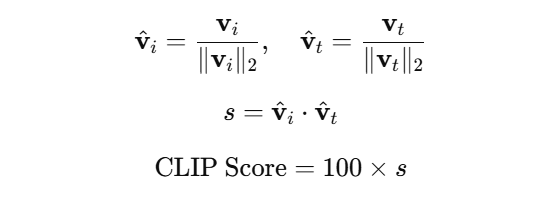




Where $\mathbf v_i$ and $\mathbf v_t$ are the raw image and text embeddings returned by the CLIP model.

The notebook implements this exactly with:

```python
img_emb = out.image_embeds / out.image_embeds.norm(dim=-1, keepdim=True)
txt_emb = out.text_embeds  / out.text_embeds.norm(dim=-1, keepdim=True)
score   = (img_emb * txt_emb).sum(-1) * 100
```


In [12]:

def batched_clip(df, batch_size=16):
    scores = []
    for i in tqdm.trange(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        images = [Image.open(p).convert("RGB") for p in batch.image_path]
        inputs = processor(images=images,
                           text=batch.prompt.tolist(),
                           return_tensors="pt",
                           padding=True).to(device)
        with torch.no_grad():
            out = model(**inputs)
        img_emb = out.image_embeds / out.image_embeds.norm(dim=-1, keepdim=True)
        txt_emb = out.text_embeds / out.text_embeds.norm(dim=-1, keepdim=True)
        cos = (img_emb * txt_emb).sum(-1) * 100   # 0‑100
        scores.extend(cos.cpu().tolist())
    return scores

manifest_df["clip"] = batched_clip(manifest_df)
manifest_df.to_csv("clip_scores_raw.csv", index=False)
display(manifest_df.head())


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


,image_path,prompt,method,clip
0,/content/AI_Avatar_Project/Generated/SD1.5/Dre...,(wide shot) of analog style modelshoot style 8...,SD15_Dreambooth,18.625000
1,/content/AI_Avatar_Project/Generated/SD1.5/Dre...,(wide shot) of analog style modelshoot style 8...,SD15_Dreambooth,15.476562
2,/content/AI_Avatar_Project/Generated/SD1.5/Dre...,(wide shot) of analog style modelshoot style 8...,SD15_Dreambooth,15.890625
3,/content/AI_Avatar_Project/Generated/SD1.5/Dre...,(wide shot) of analog style modelshoot style 8...,SD15_Dreambooth,11.882812
4,/content/AI_Avatar_Project/Generated/SD1.5/Dre...,(wide shot) of analog style modelshoot style 8...,SD15_Dreambooth,17.265625


,clip_mean,clip_std,n
method,,,
SDXL_Dreambooth,21.059375,2.583975,5
SDXL_LoRA,20.359375,1.542964,5
InstantID_Hires,20.281250,0.959635,5
Kohya_LoRA,19.715625,1.411077,5
SDXL_TextualInversion,17.671875,1.407595,5
SD15_TextualInversion,16.656250,1.715942,5
SD15_Dreambooth,15.828125,2.528928,5
SD15_LoRA,15.110938,0.809893,5


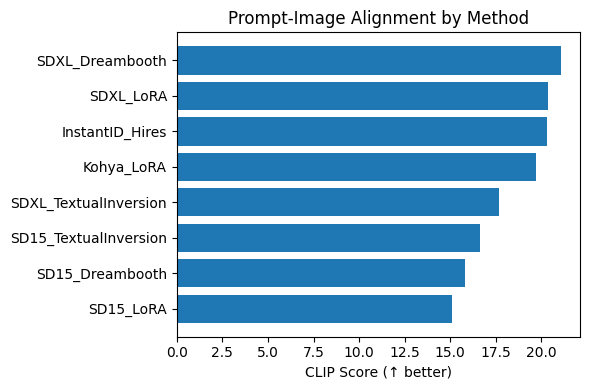

In [13]:
# @title Summarize & plot
summary = (manifest_df.groupby("method")
           .agg(clip_mean=("clip","mean"),
                clip_std =("clip","std"),
                n        =("clip","count"))
           .sort_values("clip_mean", ascending=False))
display(summary)

plt.figure(figsize=(6,4))
plt.barh(summary.index, summary.clip_mean)
plt.xlabel("CLIP Score (↑ better)")
plt.title("Prompt‑Image Alignment by Method")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
